In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_chisquare
from scipy.stats import chisquare
import pickle
from bs4 import BeautifulSoup
from collections import defaultdict
import requests
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.stem.snowball import SnowballStemmer
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score,  roc_curve

np.random.seed(9)


In [214]:
## only need to remove punctuation and stemize
stemmer = SnowballStemmer('english')

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [215]:
df = pd.read_csv("web_scrap.csv",index_col=0).drop_duplicates()
df.columns = ['first','Overall rating','Effectiveness','Side effects','Condition','Dosage','Other conditions','Other drugs taken','Benefits','Detailed Side effects','Comments']
tem = df['first'].str.split(" ",expand=True)[[0,4,7]]
tem.columns = ['name','age','gender']
df = pd.concat([tem,df],1).drop('first',1)

In [216]:
df.groupby('Side effects').size()

Side effects
 Extremely Severe Side Effects     259
 Mild Side Effects                1341
 Moderate Side Effects             855
 No Side Effects                  1213
 Severe Side Effects               492
dtype: int64

In [217]:
df.shape

(4160, 13)

In [218]:
df['Side effects Yes/No'] = (df['Side effects'] != ' No Side Effects').astype(int)


In [219]:
train, test = train_test_split(df, test_size=0.2,random_state=100)

In [220]:
train_unsplit = train['Detailed Side effects'] + ' ' + train['Comments'] + ' '+ train['Benefits']
test_unsplit = test['Detailed Side effects'] + ' ' + test['Comments'] + ' '+ test['Benefits']

In [221]:
con_vec = TfidfVectorizer(stop_words='english',tokenizer=tokenize)
X_train = con_vec.fit_transform(train_unsplit)
y_train = train['Side effects Yes/No']

X_test = con_vec.transform(test_unsplit)
y_test = test['Side effects Yes/No']

In [222]:
## fit the model
def fit_model(model):
    model_cv_score = cross_val_score(model,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)

    model.fit(X_train,y_train)
    
    
    y_test_pred = model.predict(X_test)
    y_test_pro = model.predict_proba(X_test)
    
    acc = accuracy_score(y_test, y_test_pred)

    print("Mean_accuracy_cv:\t" + str(np.mean(model_cv_score)))
    print("Test_accuracy:\t" + str(acc))
   
    
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pro[:,1])
    auc = roc_auc_score(y_test, y_test_pro[:,1])
    print("Test_auc:\t" + str(auc))
    return fpr, tpr, thresholds
    

## Logistic Regression

In [197]:
lr = LogisticRegression(penalty='l1')
fpr_lr, tpr_lr, thresholds_lr = fit_model(lr)

Mean_accuracy_cv:	0.7557085489456995
Test_accuracy:	0.7355769230769231
Test_auc:	0.7823081121510441


## SVM linear kernel 

In [223]:
svm_lin = SVC(kernel='linear')
svm_lin_cv_score = cross_val_score(svm_lin,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)
svm_lin_cv_score

array([0.76396396, 0.77998197, 0.76735798])

In [224]:
svm_lin = SVC(kernel='linear')
svm_lin.fit(X_train,y_train)
y_test_pred = svm_lin.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.7536057692307693

In [254]:
test = pd.read_csv("../drugsCom_raw/drugsComTest_raw.tsv",sep='\t', index_col=0)
X_wit = clean_text(test,'review')
X_wit_trans = con_vec.transform(X_wit)

y_wit_pred = svm_lin.predict(X_wit_trans)

In [255]:
pos_svm_lin = list(X_wit[y_wit_pred.flatten() == 1].sample(10))
neg_svm_lin = list(X_wit[y_wit_pred.flatten() == 0].sample(10))

svm_lin_pos_neg = pd.DataFrame(pos_svm_lin,neg_svm_lin).reset_index()
svm_lin_pos_neg.columns = ['svm_lin_1','svm_lin_2']
svm_lin_pos_neg.to_csv("svm_lin_pos_neg.csv")

In [253]:
len(con_vec.get_feature_names())
len(svm_lin.coef_.toarray().ravel())

12070

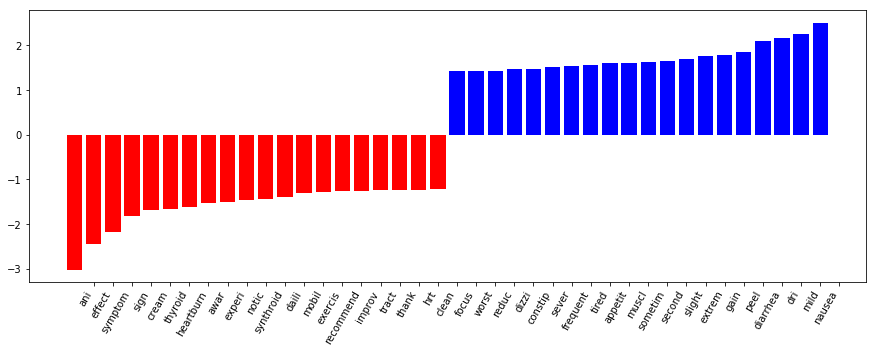

In [248]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.toarray().ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    
plot_coefficients(svm_lin, con_vec.get_feature_names())

## SVM rbf kernel

In [102]:
svm_rbf = SVC(kernel='rbf')
svm_rbf_cv_score = cross_val_score(svm_rbf,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)
svm_rbf_cv_score

array([0.71351351, 0.71325518, 0.71325518])

In [103]:
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train,y_train)
y_test_pred = svm_rbf.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.6887019230769231

## Random Forest Classifier

In [198]:
rfc = RandomForestClassifier(n_estimators=800,n_jobs=-1)
fpr_rfc, tpr_rfc, thresholds_rfc = fit_model(rfc)

Mean_accuracy_cv:	0.7355775974351267
Test_accuracy:	0.7151442307692307
Test_auc:	0.7959496519705944


In [199]:
rfc = RandomForestClassifier(n_estimators=800,n_jobs=-1)
rfc.fit(X_train,y_train)
len(rfc.feature_importances_)

12070

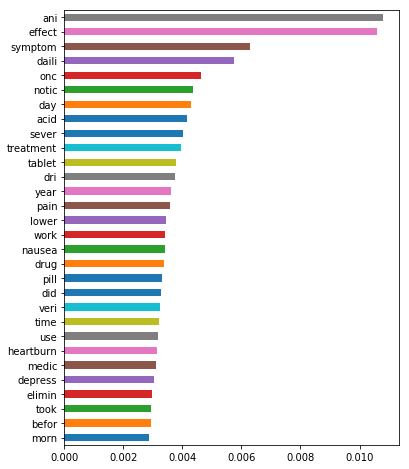

In [200]:
importance = pd.DataFrame(rfc.feature_importances_,con_vec.get_feature_names())
plt.figure(figsize=(6,8))
importance[0].sort_values(ascending=False).head(30)[::-1].plot(kind='barh')

In [201]:
test = pd.read_csv("../drugsCom_raw/drugsComTest_raw.tsv",sep='\t', index_col=0)
X_wit = clean_text(test,'review')
X_wit_trans = con_vec.transform(X_wit)

In [202]:
y_wit_pred = rfc.predict(X_wit_trans)

In [203]:
pos_rfc = list(X_wit[y_wit_pred.flatten() == 1].sample(10))
neg_rfc = list(X_wit[y_wit_pred.flatten() == 0].sample(10))

In [206]:
rfc_pos_neg = pd.DataFrame(pos_rfc,neg_rfc).reset_index()
rfc_pos_neg.columns = ['rfc_1','rfc_2']
#rfc_pos_neg.to_csv("rfc_pos_neg.csv")

In [207]:
rfc_pos_neg

,rfc_1,rfc_2
0,after two day of take tylenol day and tylenol ...,ive had my implant sinc juli of &amp ive had m...
1,this is my second day with this drug and i can...,without this i am not quit human nor quit sane...
2,effexor xr work great for hot flash not to men...,i was prescrib gabapentin for lower back pain ...
3,i have tri everi triptan and relpax is the onl...,i dont feel ani differ take this medicin i fee...
4,i suffer from sold sore veri often coupl of ti...,i had taxol with avastin for cycl each cycl wa...
5,i have been on this pill for almost a year and...,horribl had a period everi week the whole time...
6,i have now tri this medic twice the first time...,ive been on the pill for day and it definit cu...
7,love this birth control pleas dont read all th...,i am singl and am onli take this main for my a...
8,i absolut love this medic work realli fast i d...,i have been on benzodiazepin for sever yearsun...
9,ive never experienc ani type of side effect of...,befor tri moviprep i initi bought a differ lax...


## Gradient Boosting Classifier

In [108]:
gbc = GradientBoostingClassifier(n_estimators=600)
fpr_gbc, tpr_gbc, thresholds_gbc = fit_model(gbc)

Mean_accuracy_cv:	0.7457951188338926
Test_accuracy:	0.7223557692307693
Test_auc:	0.7792759101659626


## Directional LSTM

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
#from bs4 import BeautifulSoup
from collections import defaultdict
#import requests
%matplotlib inline
from sklearn.svm import SVC
from nltk.stem.snowball import SnowballStemmer

import tensorflow as tf
import tensorflow 

#from tensorflow import tensorflow.keras

#from keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional



# fix random seed for reproducibility

MAX_NB_WORDS = 500
max_review_length = 500
EMBEDDING_DIM = 160

In [130]:
def clean_text(df_tem3,col):
    df_tem3[col] = df_tem3[col].str.replace("&#039;",'\'')
    df_tem3[col] = df_tem3[col].str.replace("\"","").str.lower()
    df_tem3[col] = df_tem3[col].str.replace( r"(\\r)|(\\n)|(\\t)|(\\f)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(&#039;)|(\d\s)|(\d)|(\/)","")
    df_tem3[col] = df_tem3[col].str.replace("\"","").str.lower()
    df_tem3[col] = df_tem3[col].str.replace( r"(\$)|(\-)|(\\)|(\s{2,})"," ")
    df_tem3[col].sample(1).iloc[0]

    stemmer = SnowballStemmer('english')
    df_tem3[col] = df_tem3[col].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split(" ")]))
    return df_tem3[col]

In [131]:
train_unsplit = clean_text(train,'Detailed Side effects') + ' ' + clean_text(train,'Comments') + ' '+ clean_text(train,'Benefits')
test_unsplit = clean_text(test,'Detailed Side effects') + ' ' + clean_text(test,'Comments') + ' '+ clean_text(test,'Benefits')

/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [132]:
# Tokenize the data
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True, split=' ', char_level=False, 
                      oov_token=None, document_count=0)

tokenizer.fit_on_texts(train_unsplit)
train_sequences = tokenizer.texts_to_sequences(train_unsplit)
test_sequences = tokenizer.texts_to_sequences(test_unsplit)

# truncate and pad input sequences
X_train = sequence.pad_sequences(train_sequences, maxlen = max_review_length)
X_test = sequence.pad_sequences(test_sequences, maxlen = max_review_length)

word_index = tokenizer.word_index

In [133]:
nb_words  = min(MAX_NB_WORDS, len(word_index))
lstm_out = max_review_length

model = Sequential()
model.add(Embedding(nb_words,EMBEDDING_DIM,input_length=max_review_length))
#model.add(Dropout(0.2))

## add conv using kernal No.32 and size 3x3, actiation='relu'(rm neg)
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPool1D(pool_size=2))
model.add(Bidirectional(LSTM(20, return_sequences=True)))
#model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(20)))
#model.add(Attention(max_review_length))
model.add(Dense(1, activation = 'sigmoid'))

## one-code mutiple categories targets use 'categorical_crossentropy' not 'binary_crossentropy'
model.compile(loss='binary_crossentropy',optimizer='adam',metrics =['accuracy'])

In [134]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 160)          80000     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 500, 40)           28960     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 118,761
Trainable params: 118,761
Non-trainable params: 0
_________________________________________________________________


In [135]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Run LSTM Model
batch = 32 
epoch = 40

early_stopping = EarlyStopping(patience = 3)

filepath="wb_20nue_2layer.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

LSTM_model = model.fit(X_train, y_train, batch_size=batch, epochs=epoch,
                       validation_split=0.2,callbacks=[early_stopping,checkpoint], shuffle = True)

best_score = min(LSTM_model.history['val_loss'])

/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2662 samples, validate on 666 samples
Epoch 1/40
2656/2662 [============================>.] - ETA: 0s - loss: 0.6078 - acc: 0.7139
Epoch 00001: val_acc improved from -inf to 0.71171, saving model to wb_20nue_2layer.best.hdf5
2662/2662 [==============================] - 72s 27ms/step - loss: 0.6079 - acc: 0.7137 - val_loss: 0.5968 - val_acc: 0.7117
Epoch 2/40
2656/2662 [============================>.] - ETA: 0s - loss: 0.5548 - acc: 0.7248
Epoch 00002: val_acc improved from 0.71171 to 0.74174, saving model to wb_20nue_2layer.best.hdf5
2662/2662 [==============================] - 67s 25ms/step - loss: 0.5544 - acc: 0.7250 - val_loss: 0.5534 - val_acc: 0.7417
Epoch 3/40
2656/2662 [============================>.] - ETA: 0s - loss: 0.4504 - acc: 0.8110
Epoch 00003: val_acc improved from 0.74174 to 0.86637, saving model to wb_20nue_2layer.best.hdf5
2662/2662 [==============================] - 67s 25ms/step - loss: 0.4502 - acc: 0.8110 - val_loss: 0.3966 - val_acc: 0.8664
Epoch 4/40


In [136]:
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model
#model = load_model("web_20_bilstm_2layer.h5")
#LSTM_model = model.fit(X_train, y_train, batch_size=batch, epochs=epoch)

accr = model.evaluate(X_test,y_test, batch_size = 100)
accr

832/832 [==============================] - 2s 2ms/step


[0.47956806464264023, 0.8329327026238809]

In [137]:
model2 = load_model(filepath)
model2.evaluate(X_test,y_test, batch_size = 100)

/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


832/832 [==============================] - 3s 4ms/step


[0.4106566881617674, 0.867788454087881]

In [138]:
y_test_pro = model2.predict_proba(X_test)

In [139]:
fpr_LSTM, tpr_LSTM, thre_LSTM = roc_curve(y_test,y_test_pro)

In [141]:
roc_auc_score(y_test,y_test_pro)

0.8431273457451469

Text(0.5,0,'1-Specificity (FPR=1-TNR)')

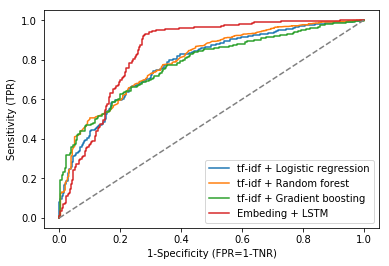

In [211]:
plt.plot(fpr_lr, tpr_lr, label='tf-idf + Logistic regression')
plt.plot(fpr_rfc, tpr_rfc, label = 'tf-idf + Random forest')
plt.plot(fpr_gbc, tpr_gbc, label = 'tf-idf + Gradient boosting')
plt.plot(fpr_LSTM, tpr_LSTM, label = 'Embeding + LSTM')
plt.plot([0,1],[0,1],color='grey', linestyle='dashed')

plt.legend()
plt.ylabel("Sensitivity (TPR)")
plt.xlabel("1-Specificity (FPR=1-TNR)")

## Randomly sample 10 comments from other resource predict to be with/without side effects

In [152]:
test = pd.read_csv("../drugsCom_raw/drugsComTest_raw.tsv",sep='\t', index_col=0)
X_wit = clean_text(test,'review')

X_wit_sequences = tokenizer.texts_to_sequences(X_wit)
X_wit_trans = sequence.pad_sequences(X_wit_sequences, maxlen = max_review_length)

In [154]:
y_test_pred = model2.predict_classes(X_wit_trans)

In [180]:
pos_LSTM = list(X_wit[y_test_pred.flatten() == 1].sample(10))
neg_LSTM = list(X_wit[y_test_pred.flatten() == 0].sample(10))

In [208]:
LSTM_pos_neg = pd.DataFrame(pos_LSTM,neg_LSTM).reset_index()
LSTM_pos_neg.columns = ['LSTM_1','LSTM_2']
#LSTM_pos_neg.to_csv("LSTM_pos_neg.csv")

In [181]:
for sen in pos_LSTM:
    print(sen+"\n")
    print("==================================")

i was prescrib this to reduc my heavi period which had been contribut to my aneamia   i had been get annual iron transfus for the previous three year im on two three time per day for four day they work as in have reduc my bleed signific i have not notic ani side effect dure the day i take them initi when i took the tablet i would keep spot for up to day but the last few month my period is all over by day my period have gone from a day cycl to a day cycl   so im assum this is a side effect i do get some slight pre period cramp in the  day befor i get my period now which i have not had previous my altern to take this were get a mirena implant

ive had this birth control sinc april and i have not had a singl period ive spot a coupl of time but never an actual period i also notic a signific weight gain was wonder if it becaus i dont get a period and what can i do other than that it the best birth control ive use

excel medic veri effect for insomnia and mild depress if you wake up feel gro

In [182]:
for sen in neg_LSTM:
    print(sen+"\n")
    print("==================================")

my son has been take symbicort for year and it has work well he start feel fatigu about a year ago and has been diagnos in the last week with adren suppressionshutdown which is a note possibl reaction if ani user feel fatigu or have difficulti fight infect i would suggest get cortisol test prompt

been take nplate for year i take n plate week no side affect been keep my count abov most of the time higher count is over 

this is a medicin my son is usingabus it is high addict i see no benefit for long term use even after day rehab he went straight back to his doctor and lie about the natur of his treatment and got a new suppli he basic sleep walk through the day befor this he never use anyth stronger than asprin

i am year old had no energi gain a lot of weight woke up sweat at night felt terribl it took me doctor but the last one said it was obvious estrogen defici i have been take the mylan mg transderm patch and i feel reborn i have energi im not hot i feel great onli problem is the 